<a href="https://colab.research.google.com/github/nishithewel/ID5059GroupProject/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
!git clone https://github.com/nishithewel/ID5059GroupProject.git

Cloning into 'ID5059GroupProject'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 216 (delta 117), reused 92 (delta 42), pack-reused 0
Receiving objects: 100% (216/216), 14.47 MiB | 9.24 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [90]:
! git pull

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


### Downloading the Data from kaggle.

In [ ]:

!pip install -q kaggle
from google.colab import files
files.upload()
!rm -rf sample_data
!mkdir  -p /root/.kaggle/
!mv kaggle.json  /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!ls -lart /root/.kaggle/
!kaggle competitions download -c 'ieee-fraud-detection'
!mkdir data
!mv ieee-fraud-detection.zip data/
!unzip data/ieee-fraud-detection.zip -d data/

Saving kaggle.json to kaggle.json
total 16
-rw------- 1 root root   66 Apr  7 09:43 kaggle.json
drwx------ 1 root root 4096 Apr  7 09:43 ..
drwxr-xr-x 2 root root 4096 Apr  7 09:43 .
 96% 113M/118M [00:03<00:00, 31.2MB/s]
100% 118M/118M [00:03<00:00, 33.3MB/s]
Archive:  data/ieee-fraud-detection.zip
  inflating: data/sample_submission.csv  
  inflating: data/test_identity.csv  
  inflating: data/test_transaction.csv  
  inflating: data/train_identity.csv  
  inflating: data/train_transaction.csv  


## Introduction to the Dataset

 - Vivesh 

### Team Members
- Nishithe Welandawe - naw4
- Joseph Edwards - jde1
- Anli Hu - 373
- Yao-Ting Wang - ytw1
-


### Installs and Imports

In [ ]:
! pip install imblearn 

In [3]:
import os

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive


os.chdir('/content/ID5059GroupProject')
from imblearn import over_sampling
from utils.preprocess import preprocess
from utils.reduce_memory import reduce_mem_usage
from sklearn.model_selection import train_test_split
from utils.model_stack import stack_models
from random import sample


### Loading the dataset

- Download the dataset from Kaggle and save it the GDrive session.
- Due to the large size, to keep loading size down we optimize data types to reduce memory usage.
- Merge the Transaction and Identity data set to create the 'Test' set.



In [ ]:
### You need to change these codes to load your dataset
#if youre files are stored in google drive do this
DRIVE_STORE = True
if DRIVE_STORE == True:
  drive.mount('/content/drive') 
  root_dir = '/content/drive/MyDrive/Python/ID5059-GroupProject/ieee-fraud-detection/' #for nish
  
else:
  root_dir = '/content/data/'
os.chdir(root_dir)

test_iden = pd.read_csv(root_dir + 'test_identity.csv',)
test_tran = pd.read_csv(root_dir +'test_transaction.csv',)
train_iden = pd.read_csv(root_dir +'train_identity.csv',)
train_tran = pd.read_csv(root_dir +'train_transaction.csv',)


test_tran = reduce_mem_usage(test_tran)
train_tran = reduce_mem_usage(train_tran)  




train = pd.merge(train_tran, train_iden, on = 'TransactionID', how = 'left')
test = pd.merge(test_tran, test_iden, on = 'TransactionID', how = 'left')


test_ind = sample(range(len(train),0.8*len(train)))
#but we need a local test to run diagnostics as well
local_test = train[test_ind]
#drop rows from train
train = train.drop(test_ind,axis = 0)

del train_tran, train_iden, test_iden, test_tran


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:

test_ind = sample(range(len(train)),int(0.8*len(train)))
#but we need a local test to run diagnostics as well
local_test = train.iloc[test_ind]
#drop rows from train
train = train.drop(test_ind,axis = 0)

del train_tran, train_iden, test_iden, test_tran

Test_dataset and train_dataset had a mismatch in the name of id features. In the train_dataset id features were present with the name id_x where x was a value between 01 and 38 whereas in the test_dataset id features were of the form id-x. So, we changed the format of id features in the test_dataset from id-x to id_x.

In [12]:
test.columns  = [col.replace('-','_') for col in test.columns]

## EDA
We perform basic analysis on the data.
- Visualise predictor distribution.
- Correlation


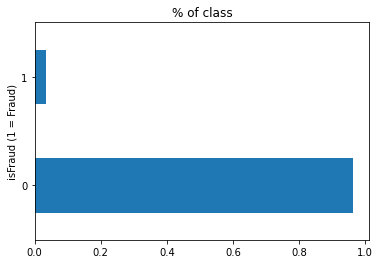

In [13]:
train['isFraud'].value_counts(normalize = True).plot(kind= 'barh')
plt.title('% of class')
plt.ylabel('isFraud (1 = Fraud)')
plt.show()

We find very few instance of Fraud. Consider Class Balancing.

## Feature Preproccessing

Systematically, deal with features by considering the following,
- 'M' columns - look like true or false lets convert them to 1, 0
- 'D' columns - these are fine all numerical
- 'C' columns - numerical except for 4,6

We deal with categorical variables using dummy vars.

In [81]:

train = preprocess(train)
test = preprocess(test)
local_test = preprocess(local_test)

#the M columns look like true or false lets convert them to 1, 0 
m_cols = [col for col in train.columns if col.startswith('M')]
# m_cols.head()


KeyError: ignored


What features are we dropping and why?

- TransactionID - Only a unique identifier for identity
- Id Columns - All Id columns contain at least 75% NaN values 


In [ ]:
id_cols = [col for col in train.columns if col.startswith('id')]
df_id = train[id_cols]
# df_id.head()
nulls = df_id.isnull().sum()/len(df_id) #as a percentage
nulls.sort_values(ascending=False).plot.bar(title='NaN as a %')
# train.drop(id_cols, axis = 1,inplace = True)

In [ ]:
#Run this otherwise might cause ram overflows
v_cols = [col for col in train.columns if col.startswith('V')]
# # lets ignore the v columns for the time being
train.drop(v_cols,axis =1, inplace = True)
train.drop(id_cols, axis = 1,inplace = True)

In [ ]:
categorical_features = list(set(train.columns) - set(train._get_numeric_data().columns))
get_dummy_cols = []
for col in categorical_features:
  print('# of unique cats in',col,' is', len(train[col].unique()) )
  if len(train[col].unique()) < 15:
    get_dummy_cols.append(col)

In [ ]:



from sklearn.preprocessing import OneHotEncoder  #the disco import 

for col in get_dummy_cols:
  enc = OneHotEncoder(handle_unknown='ignore',sparse=False) 
  dummy_train = enc.fit_transform(train[col].to_numpy().reshape(-1, 1))
  new_col = [ col+'_' + str(i)  for i in enc.categories_[0].tolist()]


  # for df in [train, test]:
  dummy_test = enc.transform(test[col].to_numpy().reshape(-1, 1))

  dummy_dftest = pd.DataFrame(dummy_test, columns = new_col)
  dummy_dftrain = pd.DataFrame(dummy_train, columns = new_col)

  test = pd.concat([test, dummy_dftest],axis =1)
  train = pd.concat([train, dummy_dftrain],axis =1)
  
    # df.drop(col,axis =1,inplace=True)
  
train.columns

We need to deal with the variables with high number of cats.

In [ ]:
train.drop(get_dummy_cols,axis =1,inplace = True )
test.drop(get_dummy_cols,axis =1,inplace = True )

In [ ]:
# large_cats = list(set(train.columns) - set(train._get_numeric_data()))
# large_cats

In [ ]:
for col in large_cats:
  print(col,train[col].unique()[:5])

In [ ]:
def frequency_encoder(x,groupby):
  if x == None:
    return groupby[np.nan]
  else:
    return groupby[x]


  # large_cats
for col in large_cats:
  freq_enc = (train.groupby(col,dropna=False  # to prevent loss of information
                            ).size()) / len(train)
  train[col+'freq'] = train[col].apply(lambda x : frequency_encoder(x,freq_enc))
  # train.drop(col,axis= 1 , inplace = True)
train.drop(large_cats,axis = 1,inplace = True)


### Column Imputation
How are we dealing with NaN/Missing/Infinite Values?



In [ ]:
train.info()

In [ ]:
nulls = train.isnull().sum()/len(train)
nulls.sort_values()

In [ ]:
train_na = train.dropna(thresh= 0.8 * len(train),axis = 1)

In [ ]:
nulls = train_na.isnull().sum()/len(train_na) #as a percentage
nulls.sort_values(ascending=False).plot.barh(title='NaN as a %')

### Feauture Cleaning
The data contains outliers, which require cleaning.

### Feature engineering (Creation)
Wrapped as Preprocessor function to be implemented after test train split.

### Class Balancing

In [ ]:
train_no_na = train_na[~train_na.isin([np.nan, np.inf, -np.inf]).any(1)]
train_no_na = train_no_na._get_numeric_data()
X_train, y_train = train_no_na.drop('isFraud',axis = 1), train_no_na['isFraud']
oversample = over_sampling.SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_train.drop('TransactionID', axis=1, inplace = True)

## Model Creation & Fitting


### Individiual models

In [ ]:

# model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
# model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=True)

In [ ]:
#naw4
from sklearn.model_selection import RandomizedSearchCV
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

# train.drop(['P_emaildomain', 'R_emaildomain'],axis =1 ,inplace = True)
from sklearn.metrics import accuracy_score

import xgboost as xgb

xgb_cl = xgb.XGBClassifier()

# clf = RandomizedSearchCV(estimator=xgb_cl,
#                          param_distributions=params,
#                          n_jobs = -1,
#                         #  scoring='neg_mean_squared_error',
#                          n_iter=25,
#                          verbose=1)
# search = clf.fit(X_train, y_train)



xgb_cl.fit(X_train, y_train)
preds = xgb_cl.predict(X_train)
accuracy_score(y_train, preds)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


KeyboardInterrupt: ignored

In [ ]:
# clf.get_params()

<bound method BaseEstimator.get_params of RandomizedSearchCV(estimator=XGBClassifier(), n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 6, 10, 15, 20],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   verbose=1)>

In [ ]:
bst.save_model('model_file_name.json')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_train, preds,normalize='true')

In [ ]:
#jde1
from sklearn import datasets, svm
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import LinearSVC
# train.drop(['P_emaildomain', 'R_emaildomain'],axis =1 ,inplace = True)

percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_df = pd.DataFrame({'column_name': train.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
high_na = list(missing_value_df.loc[missing_value_df['percent_missing']>0.2]['column_name'])

j_train = train.drop(high_na, axis = 1)
j_train.dropna(inplace=True)

X_train, y_train = j_train.drop('isFraud',axis = 1), j_train['isFraud']

# imp = SimpleImputer(strategy="most_frequent")
# j_train = imp.fit_transform(j_train)
clf = svm.LinearSVC()

feature_map_nystroem = Nystroem(gamma=.2,
                                 random_state=1,
                                 n_components=300)
data_transformed = feature_map_nystroem.fit_transform(X_train)
clf.fit(data_transformed, y_train)
LinearSVC()
preds = clf.predict(data_transformed)
accuracy_score(y_train, preds)

In [ ]:
preds = clf.predict(data_transformed)
accuracy_score(y_train, preds)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_train, preds,normalize='true')

In [ ]:
! pip uninstall lightgbm -y

# install lightgbm GPU
! pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"


Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 1.5 MB 4.3 MB/s 
Skipping wheel build for lightgbm, due to binaries being disabled for it.
    Running setup.py install for lightgbm ... done


In [ ]:
#anli
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'device':'gpu',
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 5313,
         }
from sklearn.model_selection import train_test_split
score = 0

feature_importances = pd.DataFrame()
lgb_X_train, lgb_X_valid,lgb_y_train, lgb_y_valid=train_test_split(X_train,y_train,train_size=0.8)
dtrain = lgb.Dataset(lgb_X_train, label=lgb_y_train)
dvalid = lgb.Dataset(lgb_X_valid, label=lgb_y_valid)
clf = lgb.train(params, dtrain, 4000, valid_sets = [dtrain, dvalid])

feature_importances = clf.feature_importance()

y_pred_valid = clf.predict(lgb_X_valid)
score = roc_auc_score(lgb_y_valid, y_pred_valid)

print(f"AUC = {score}")

LightGBMError: ignored

### Model Ensembling

In [ ]:
stack_models(('Nishi', xgb_cl))